<a href="https://colab.research.google.com/github/MSHDZ1/Q_late-night/blob/main/VF4_Experiment_Assigment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Setup
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

data = pd.read_csv('/content/rocketfuel_deciles.csv')
print(data.describe())
data.head ()

            user_id           test      converted       tot_impr  \
count  5.881010e+05  588101.000000  588101.000000  588101.000000   
mean   1.310692e+06       0.960000       0.025239      24.820876   
std    2.022260e+05       0.195959       0.156850      43.715181   
min    9.000000e+05       0.000000       0.000000       1.000000   
25%    1.143190e+06       1.000000       0.000000       4.000000   
50%    1.313725e+06       1.000000       0.000000      13.000000   
75%    1.484088e+06       1.000000       0.000000      27.000000   
max    1.654483e+06       1.000000       1.000000    2065.000000   

       mode_impr_day  mode_impr_hour  tot_impr_decile  
count  588101.000000   588101.000000    588101.000000  
mean        4.025533       14.469061         5.448068  
std         2.004019        4.834634         2.862418  
min         1.000000        0.000000         1.000000  
25%         2.000000       11.000000         3.000000  
50%         4.000000       14.000000         5.0000

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour,tot_impr_decile
0,1391842,1,0,2,3,19,2
1,1215269,1,0,1,4,12,1
2,1604030,1,0,2,6,11,2
3,1278452,1,0,1,7,18,1
4,1363432,1,0,1,6,13,1


Looking at summary statistics:


*   Test Variable, the mean shows a 96% that means that this percentage of user was exposed to the ad. This makes sense as the business case explained that a control group of 4% was desired.
*   Converted, shows a mean of 2.5%.
*   Tot_imp_decile, 10 equal size groups.






In [3]:
print(data.isnull().sum())

user_id            0
test               0
converted          0
tot_impr           0
mode_impr_day      0
mode_impr_hour     0
tot_impr_decile    0
dtype: int64


In [4]:
#Check for balance: In a table, compare the shares of individuals by treatment status,
#and the means and standard deviations of pre-experiment variables.
#Comment on your findings.

print(data.mean())

balance_table = data [['test', 'converted', 'tot_impr', 'mode_impr_day', 'mode_impr_hour', 'tot_impr_decile']].groupby('test').agg(['mean', 'std'])
print(balance_table)

user_id            1.310692e+06
test               9.600001e-01
converted          2.523886e-02
tot_impr           2.482088e+01
mode_impr_day      4.025533e+00
mode_impr_hour     1.446906e+01
tot_impr_decile    5.448068e+00
dtype: float64
     converted             tot_impr            mode_impr_day            \
          mean       std       mean        std          mean       std   
test                                                                     
0     0.017854  0.132424  24.761138  42.860720      3.952644  1.948943   
1     0.025547  0.157778  24.823365  43.750456      4.028570  2.006226   

     mode_impr_hour           tot_impr_decile            
               mean       std            mean       std  
test                                                     
0         14.304923  4.656239        5.325030  2.922811  
1         14.475900  4.841808        5.453194  2.859762  


We can see a slight higher convertion in the treatment group. We will further our analysis to revise if this is statistically significant.

From the mean in the pre-experiment variables we can determine that the treatment and control groups are well balanced., there are only minor differnces in mean.

In [5]:
treatment_shares = data['test'].value_counts(normalize=True)
print("Shares of Individuals by Treatment Status:")
print(treatment_shares)


Shares of Individuals by Treatment Status:
test
1    0.96
0    0.04
Name: proportion, dtype: float64


In [6]:
#Plot outcome: Plot the means and confidence intervals of the main outcome “converted,”
##treatment status. In your markdown, file, interpret the result (mean and confidence intervals, noting width).

p_means = data.groupby('test')['converted'].agg(
    mean = ('mean'),
    std = ('std'),
    N = ('size')
)
p_means['se'] = p_means['std']/np.sqrt(p_means['N'])
p_means['lb'] = p_means['mean'] - 1.96*p_means['se']
p_means['ub'] = p_means['mean'] + 1.96*p_means['se']


print(p_means[['mean', 'lb', 'ub', 'std']])


          mean        lb        ub       std
test                                        
0     0.017854  0.016162  0.019546  0.132424
1     0.025547  0.025135  0.025958  0.157778


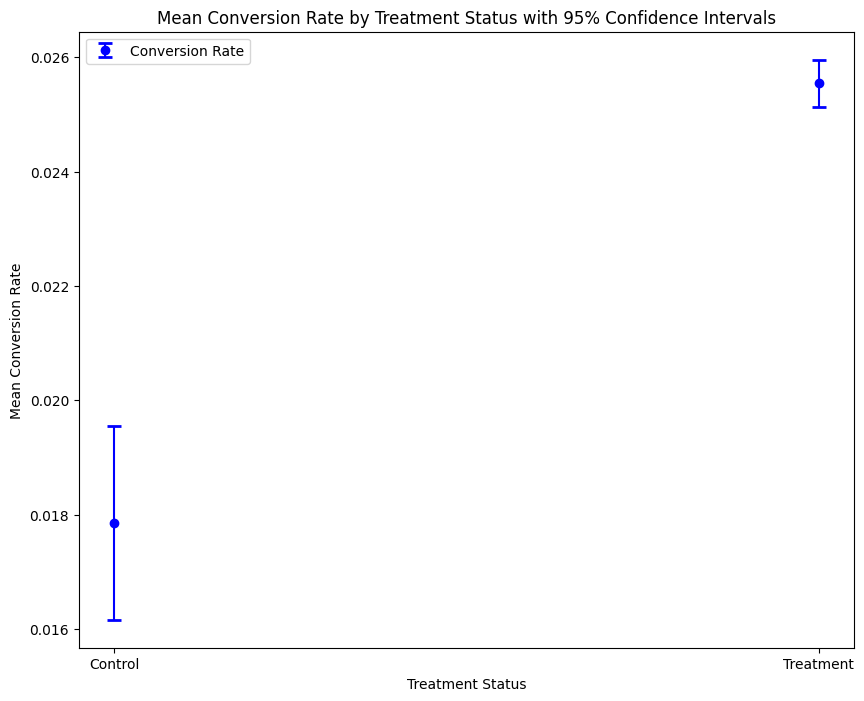

In [7]:
#Plot

plt.figure(figsize=(10, 8))
plt.errorbar(
    x=p_means.index,
    y=p_means['mean'],
    yerr=[p_means['mean'] - p_means['lb'], p_means['ub'] - p_means['mean']],
    fmt='o',
    capsize=5,
    capthick=2,
    color='blue',
    label='Conversion Rate'
)

# Add labels and title
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.xlabel('Treatment Status')
plt.ylabel('Mean Conversion Rate')
plt.title('Mean Conversion Rate by Treatment Status with 95% Confidence Intervals')
plt.legend()

The control group has a mean conversion rate of 0.017854 and confidence intervals [0.016162, 0.019546]

Then treatment grup has a mean 0.025547 conversion rate and confidence intervals [0.025135  0.025958]

The conficence interval between the two groups are not overlapping, this indicates that the conversion rate between the two groups might be statistically significant and not due to randomization. The treatment group shows a higher mean that the control, also it shows narrower confidence intervals. This might be due to the fact that the sample size is quite large for the treatment group, not so for the control group.



In [8]:
#Find ATE: Estimate of the Average Treatment Effect (ATE)
#of the ads for treatment relative to control, the associated standard error,
#and the 95% confidence interval on the Average Treatment Effects.
#You can do this by hand or with regression (but be careful about standard errors).

p_ate = p_means['mean']- p_means['mean'][0]
p_ate = p_ate.to_frame(name='ate')
print(p_ate)

p_ate['se'] = np.sqrt( p_means['se']**2 + p_means['se'][0]**2 )
p_ate['lb'] = p_ate['ate'] - 1.96*p_ate['se']
p_ate['ub'] = p_ate['ate'] + 1.96*p_ate['se']

print(p_ate[['se','ate', 'lb', 'ub']])

           ate
test          
0     0.000000
1     0.007692
            se       ate        lb        ub
test                                        
0     0.001221  0.000000 -0.002393  0.002393
1     0.000889  0.007692  0.005951  0.009434


In [9]:
#use regression
formula = 'converted ~ C(test)'
model = smf.ols(formula, data= data ).fit()
model = model.get_robustcov_results(cov_type='HC3')
print(model.summary() )

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     74.94
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           4.86e-18
Time:                        02:54:38   Log-Likelihood:             2.5499e+05
No. Observations:              588101   AIC:                        -5.100e+05
Df Residuals:                  588099   BIC:                        -5.099e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0179      0.001     20.678   

In [10]:
## Alternative way of making our HTE table

#Grouping by: 'tot_impr_decile' & 'test', calculate mean and standard error (sem) for 'converted'
alt_table = data.groupby(['tot_impr_decile', 'test'])['converted'].agg(
    mean='mean', sem='sem')

#Unstack the table to separate control and treatment columns
alt_table = alt_table.unstack()

#3Calculate HTE (treatment mean - control mean), Lift, and Confidence Intervals
alt_table['HTE'] = alt_table['mean'][1] - alt_table['mean'][0]
alt_table['Lift1'] = (alt_table['HTE'] / alt_table['mean'][0])
alt_table['se_HTE'] = np.sqrt(alt_table['sem'][1]**2 + alt_table['sem'][0]**2)
alt_table['lb1'] = alt_table['HTE'] - 1.96 * alt_table['se_HTE']
alt_table['ub1'] = alt_table['HTE'] + 1.96 * alt_table['se_HTE']

# Renaming columns for clarity
alt_table = alt_table.rename(columns={
    'mean': 'Control Mean',
    'HTE': 'HTE',
    'lb1': 'CI_Lower',
    'ub1': 'CI_Upper',
    'Lift1': 'Lift'
})

print(alt_table[['Control Mean', 'HTE', 'CI_Lower', 'CI_Upper', 'Lift', 'se_HTE']])


                Control Mean                 HTE  CI_Lower  CI_Upper  \
test                       0         1                                 
tot_impr_decile                                                        
1                   0.001300  0.001584  0.000284 -0.001224  0.001792   
2                   0.002155  0.002575  0.000421 -0.001221  0.002062   
3                   0.005208  0.003431 -0.001777 -0.004761  0.001206   
4                   0.005622  0.004210 -0.001412 -0.004398  0.001574   
5                   0.006667  0.006833  0.000166 -0.003260  0.003593   
6                   0.008074  0.007788 -0.000286 -0.004561  0.003990   
7                   0.013899  0.012946 -0.000953 -0.005490  0.003583   
8                   0.019807  0.022742  0.002934 -0.003528  0.009396   
9                   0.034467  0.052401  0.017933  0.010149  0.025717   
10                  0.084124  0.145999  0.061875  0.050438  0.073312   

                     Lift    se_HTE  
test                     

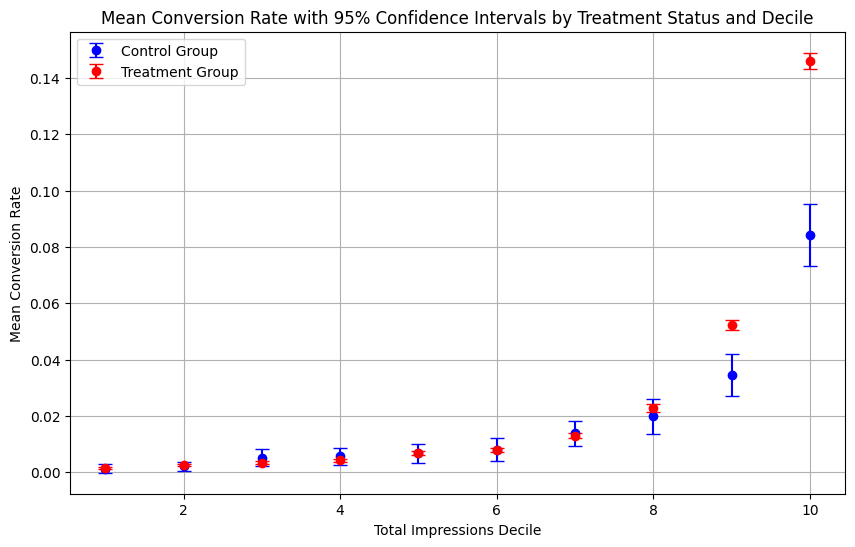

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract control and treatment means and confidence intervals separately
control_means = alt_table['Control Mean'][0]
treatment_means = alt_table['Control Mean'][1]
control_ci_lower = control_means - 1.96 * alt_table['sem'][0]
control_ci_upper = control_means + 1.96 * alt_table['sem'][0]
treatment_ci_lower = treatment_means - 1.96 * alt_table['sem'][1]
treatment_ci_upper = treatment_means + 1.96 * alt_table['sem'][1]

# Plotting
plt.figure(figsize=(10, 6))

# Plot Control Group Mean and CI as points with error bars
plt.errorbar(control_means.index, control_means.values,
             yerr=[control_means.values - control_ci_lower.values,
                   control_ci_upper.values - control_means.values],
             fmt='o', color='blue', label='Control Group', capsize=5)

# Plot Treatment Group Mean and CI as points with error bars
plt.errorbar(treatment_means.index, treatment_means.values,
             yerr=[treatment_means.values - treatment_ci_lower.values,
                   treatment_ci_upper.values - treatment_means.values],
             fmt='o', color='red', label='Treatment Group', capsize=5)

# Labels and Title
plt.xlabel('Total Impressions Decile')
plt.ylabel('Mean Conversion Rate')
plt.title('Mean Conversion Rate with 95% Confidence Intervals by Treatment Status and Decile')
plt.legend()
plt.grid(True)
plt.show()


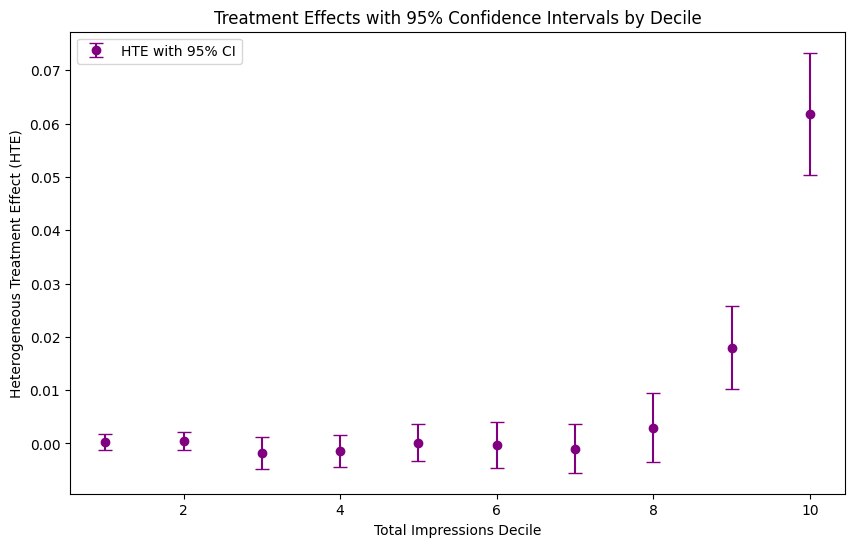

In [16]:
import matplotlib.pyplot as plt

# Assuming 'alt_table' contains HTE and CI values for each decile
# Extract deciles, HTE values, and confidence intervals
deciles = alt_table.index
hte_values = alt_table['HTE']
ci_lower = alt_table['CI_Lower']
ci_upper = alt_table['CI_Upper']

# Plotting HTE with 95% confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(deciles, hte_values, yerr=[hte_values - ci_lower, ci_upper - hte_values],
             fmt='o', color='purple', capsize=5, label='HTE with 95% CI')

# Labels and Title
plt.xlabel('Total Impressions Decile')
plt.ylabel('Heterogeneous Treatment Effect (HTE)')
plt.title('Treatment Effects with 95% Confidence Intervals by Decile')
plt.legend()
plt.show()


In [23]:
#Case Information
markup_per_sale = 40
CPM = 9

ate_on_conversions = alt_table['HTE'].mean()

average_impressions_treatment = data[data['test'] == 1]['tot_impr'].mean()
ad_spending_per_person = (CPM / 1000) * average_impressions_treatment

# Return on advertising spending
return_on_ad_spend = (ate_on_conversions * markup_per_sale) / ad_spending_per_person

print("Return on Advertising Spending:", round(return_on_ad_spend, 4))


Return on Advertising Spending: 1.4178


In [33]:
#Case Information
markup_per_sale = 40
CPM_COST = 9 / 1000

roas_per_decile = []

# Loop from 1 to 10 decile
for decile in range(1, 11):
    # Filter data for the current decile
    subdata = data[data['tot_impr_decile'] == decile]

    ate_on_conversions = subdata[subdata['test'] == 1]['converted'].mean() - subdata[subdata['test'] == 0]['converted'].mean()

    average_impressions_decile = subdata['tot_impr'].mean()

    ad_spend_per_person_decile = CPM_COST * average_impressions_decile

    roas_decile = (ate_on_conversions * markup_per_sale) / ad_spend_per_person_decile if ad_spend_per_person_decile > 0 else 0

    roas_per_decile.append((decile, roas_decile, ad_spend_per_person_decile))

#Create a new dataframe 'roas'
roas_df = pd.DataFrame(roas_per_decile, columns=['Decile', 'ROAS', 'Ad Spend per Person'])

# Identify positive ROAS deciles
positive_roas_df = roas_df[roas_df['ROAS'] > 0]

print(roas_df)

   Decile      ROAS  Ad Spend per Person
0       1  1.262335             0.009000
1       2  0.773006             0.021766
2       3 -1.734076             0.041002
3       4 -0.912956             0.061867
4       5  0.066902             0.099383
5       6 -0.081680             0.139918
6       7 -0.203239             0.187651
7       8  0.456436             0.257160
8       9  1.837139             0.390461
9      10  2.321381             1.066177


In [34]:
# Calculate the return when targeting only deciles with positive ROAS

total_positive_roas = positive_roas_df['ROAS'].sum()
total_positive_ad_spend = positive_roas_df['Ad Spend per Person'].sum()

targeted_return = total_positive_roas / total_positive_ad_spend if total_positive_ad_spend > 0 else 0

print("Return on Advertising Spending if Targeting Only Positive-ROAS Deciles:", round(targeted_return, 4))


Return on Advertising Spending if Targeting Only Positive-ROAS Deciles: 3.6428
